In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import sys

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

from augmend import Augmend, FlipRot90, Elastic, Identity, IntensityScaleShift, AdditiveNoise, Scale

from tensorflow import keras
from keras.callbacks import TensorBoard  #Visulization of Accuracy and loss

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data

We assume that data has already been downloaded via notebook [1_data_JB.ipynb](1_data_JB.ipynb).  

<div class="alert alert-block alert-info">
Training data (for input `X` with associated label masks `Y`) can be provided via lists of numpy arrays, where each image can have a different size. Alternatively, a single numpy array can also be used if all images have the same size.  
Input images can either be three-dimensional (single-channel) or four-dimensional (multi-channel) arrays, where the channel axis comes last. Label images need to be integer-valued.
</div>

In [5]:
data_dir = '/home/fiche/Data_single_loci/Annotated_data/data_loci/'
os.chdir(data_dir)

# Load the training data
# ----------------------

X = sorted(glob('train/raw/*raw*.tif'))
Y = sorted(glob('train/label/*label*.tif'))

X_trn = list(map(imread,X))
Y_trn = list(map(imread,Y))
n_channel = 1 if X_trn[0].ndim == 3 else X_trn[0].shape[-1]

# Load the validation/testing data
# --------------------------------

X = sorted(glob('test/raw/*raw*.tif'))
Y = sorted(glob('test/label/*label*.tif'))

X_val = list(map(imread,X))
Y_val = list(map(imread,Y))
n_channel = 1 if X_val[0].ndim == 3 else X_val[0].shape[-1]

In [6]:
# For the training, the number of images matters but also the total number of objects annotated on these images.
# Below, the number of objects is calculated based on the manually annotated data.
# --------------------------------------------------------------------------------

n = 0
for i in range(len(Y_trn)):
    y = Y_trn[i]
    n = n + len(np.unique(y))

print('The total number of objects segmented for the training data is ' + str(n))

n = 0
for i in range(len(Y_val)):
    y = Y_val[i]
    n = n + len(np.unique(y))

print('The total number of objects segmented for the training data is ' + str(n))

The total number of objects segmented for the training data is 5429
The total number of objects segmented for the training data is 733


Normalize images and fill small label holes (in case during the manual annotation some pixels have been forgotten).

In [7]:
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 3 in axis_norm else 'independently'))
    sys.stdout.flush()

X_trn = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_trn)]
Y_trn = [fill_label_holes(y) for y in tqdm(Y_trn)]

X_val = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_val)]
Y_val = [fill_label_holes(y) for y in tqdm(Y_val)]

100%|██████████| 18/18 [00:00<00:00, 34.42it/s]


Training data consists of pairs of input image and label instances.

In [8]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2    
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

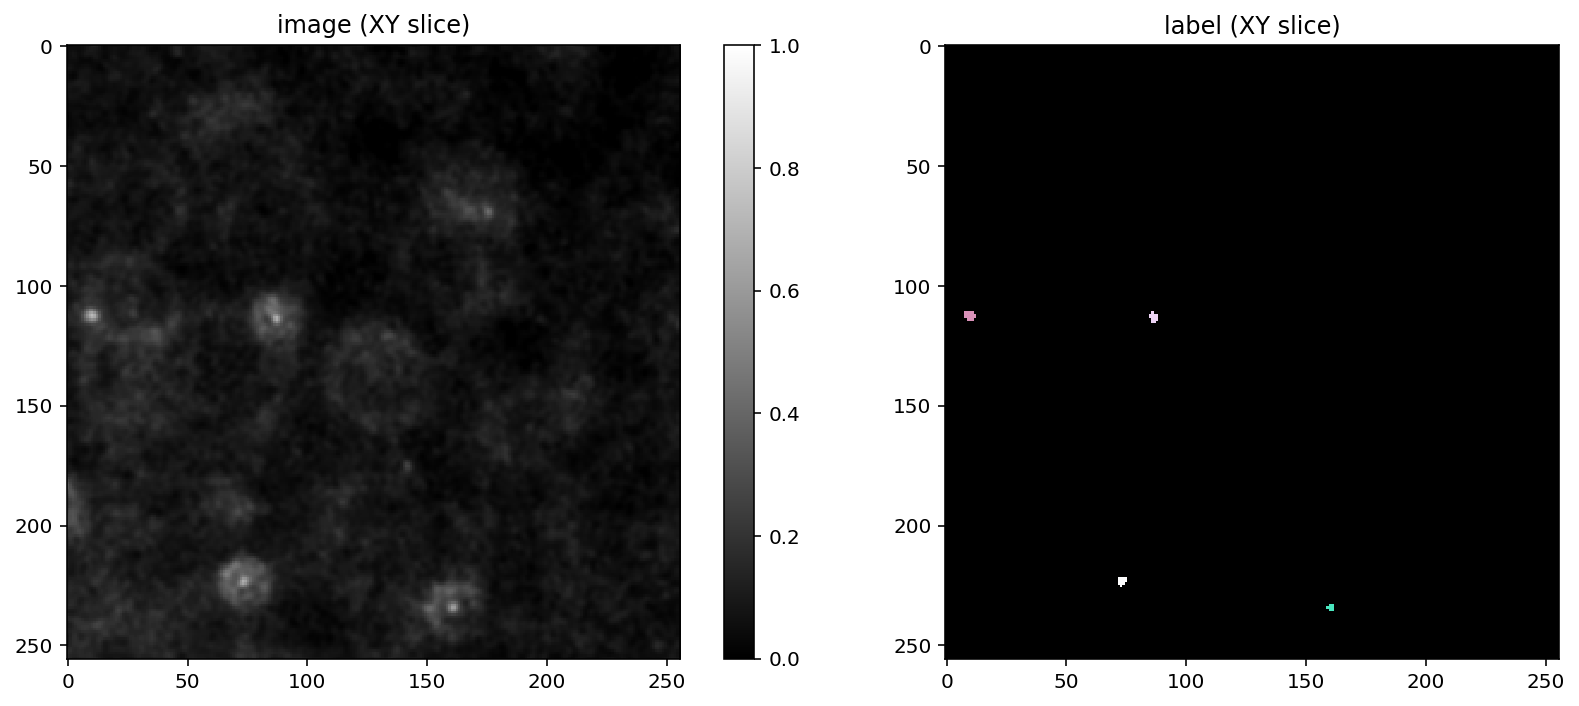

In [9]:
i = 1
img, lbl = X_trn[i], Y_trn[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

# Configuration

A `StarDist3D` model is specified via a `Config3D` object.

In [7]:
print(Config3D.__doc__)

Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int

In [8]:
extents = calculate_extents(Y_trn)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.0, 1.0555555555555556, 1.0555555555555556)


Below the parameters for StarDist are modified in order to optimize them for our sample:
- the number of rays is set to 96 as previously optimized in when analyzing the data (see 1_data_JB notebook)
- the grid is set to [1 4 4] meaning that all the pixels are taken into account along the z-axis and only 1 evry 4 pixels are taken into account in the X/Y plane. The reason is that the object are also fairly large in X/Y and taking into account all the pixels will slow down the calculation without improving the output.
- the patch size is the size of the cropped images that will be feed to the network. 48 planes are taken into account. In X/Y 128 is enough since most of the objects are in average close to this size. 
- By default, the backbone of the network is a resnet. But the perception field of this network is smaller. Therefore, when working with large cell, using the unet will increase the perception field.


Note that when using the unet as backbone, there are strong constraints on the size of the image. **The dimensions should be divided by 8.**

In [9]:
# 96 is a good default choice (see 1_data.ipynb)
n_rays = 96

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
# grid = tuple(1 if a > 1.5 else 4 for a in anisotropy)
grid = (1,1,1)
# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (60,80,80),
    train_batch_size = 2,
    backbone = 'resnet',
    train_epochs = 400,
    train_steps_per_epoch = 100
)
print(conf)
vars(conf)

Config3D(anisotropy=(1.0, 1.0555555555555556, 1.0555555555555556), axes='ZYXC', backbone='resnet', grid=(1, 1, 1), n_channel_in=1, n_channel_out=97, n_dim=3, n_rays=96, net_conv_after_resnet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (1.0, 1.0555555555555556, 1.0555555555555556)}}, resnet_activation='relu', resnet_batch_norm=False, resnet_kernel_init='he_normal', resnet_kernel_size=(3, 3, 3), resnet_n_blocks=4, resnet_n_conv_per_block=3, resnet_n_filter_base=32, train_background_reg=0.0001, train_batch_size=2, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(60, 80, 80), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 97,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 96,
 'grid': (1, 1, 1),
 'anisotropy': (1.0, 1.0555555555555556, 1.0555555555555556),
 'backbone': 'resnet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 96,
   'anisotropy': (1.0, 1.0555555555555556, 1.0555555555555556)}},
 'resnet_n_blocks': 4,
 'resnet_kernel_size': (3, 3, 3),
 'resnet_kernel_init': 'he_normal',
 'resnet_n_filter_base': 32,
 'resnet_n_conv_per_block': 3,
 'resnet_activation': 'relu',
 'resnet_batch_norm': False,
 'net_conv_after_resnet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (60, 80, 80),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'trai

In [10]:
!nvidia-smi 
gputools_available()

Thu Mar 11 18:26:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro T2000        Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8     4W /  N/A |    397MiB /  3914MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

False

In [33]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    #limit_gpu_memory(0.8)
    # alternatively, try this:
    limit_gpu_memory(None, allow_growth=True)

**Note:** The trained `StarDist3D` model will *not* predict completed shapes for partially visible objects at the image boundary.

In [11]:
model = StarDist3D(conf, name='stardist_2_no_augmentation', basedir='models')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


base_model.py (148): output path for model already exists, files may be overwritten: /home/jb/Desktop/Data_single_loci/Annotated_data/data_loci/models/stardist_2_no_augmentation


Check if the neural network has a large enough field of view to see up to the boundary of most objects.

In [12]:
median_size = calculate_extents(Y_trn, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [9.5 9.  9. ]
network field of view :  [17 17 17]


# Data Augmentation

You can define a function/callable that applies augmentation to each batch of the data generator.  
We here use an `augmenter` that applies random rotations, flips, and intensity changes, which are typically sensible for (3D) microscopy images (but you can disable augmentation by setting `augmenter = None`).

In [13]:
elastic_kwargs = dict(axis=(1,2), amount=10, use_gpu=model.config.use_gpu)
#scale_kwargs = dict(axis=1, amount=1.5, use_gpu=model.config.use_gpu)
aug = Augmend()
#aug.add([Scale(order=0,**scale_kwargs),Scale(order=0,**scale_kwargs)], probability=0.25)
aug.add([FlipRot90(axis=(1,2)),FlipRot90(axis=(1,2))])
aug.add([Elastic(order=0,**elastic_kwargs),Elastic(order=0,**elastic_kwargs)], probability=0.5)
aug.add([IntensityScaleShift(scale=(.6,2),shift=(-.2,.2)),Identity()])
aug.add([AdditiveNoise(sigma=(0.05,0.05)),Identity()], probability=0.25)

def augmenter(x,y):
    return aug([x,y])


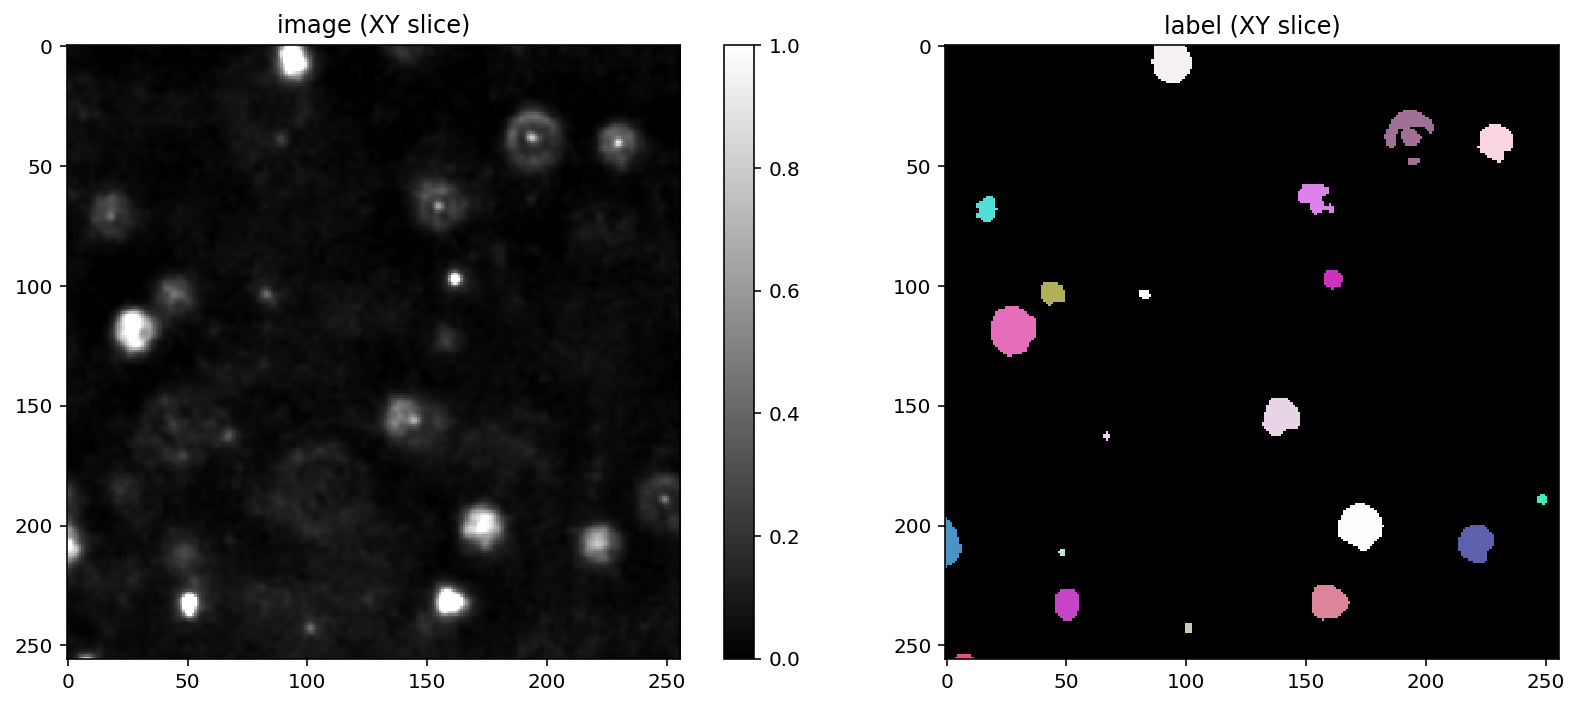

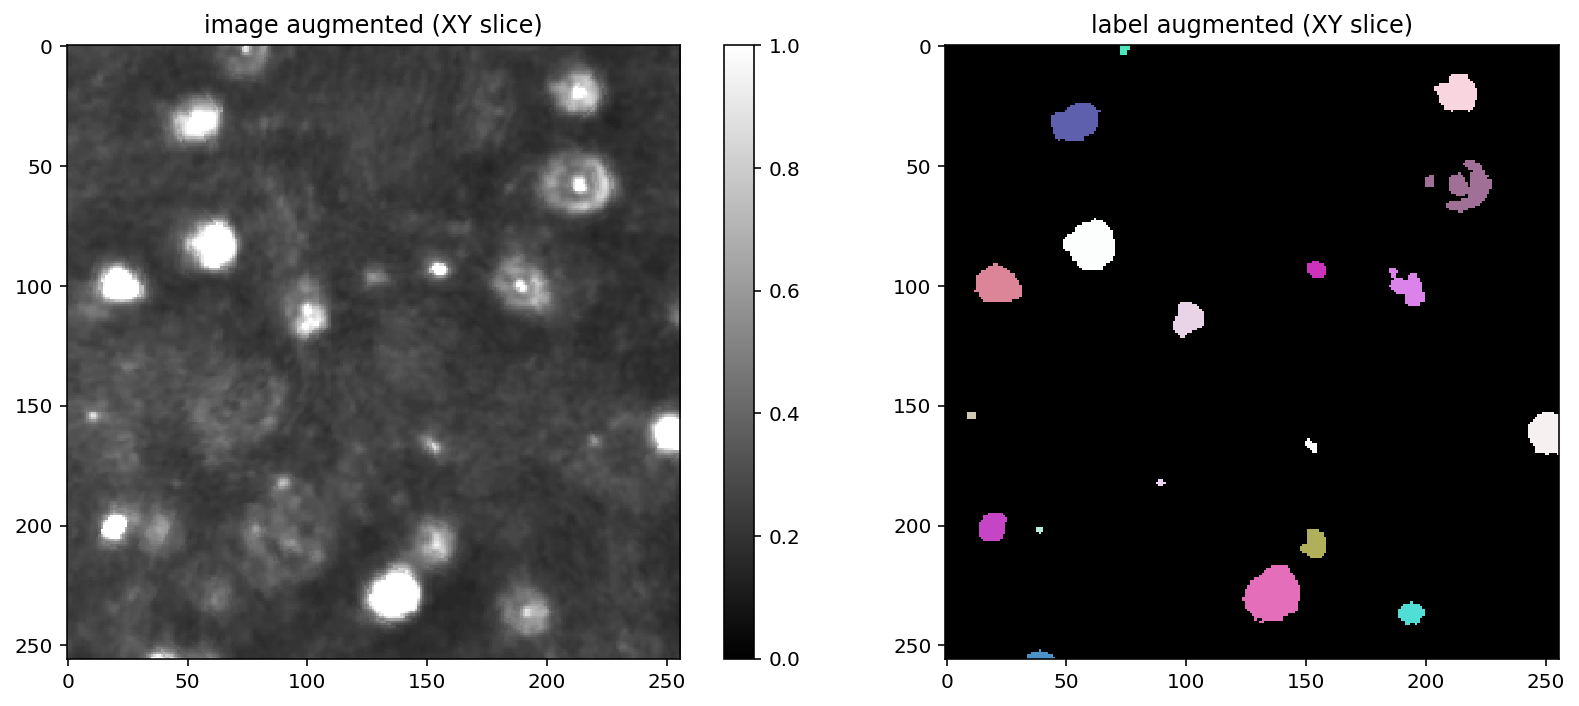

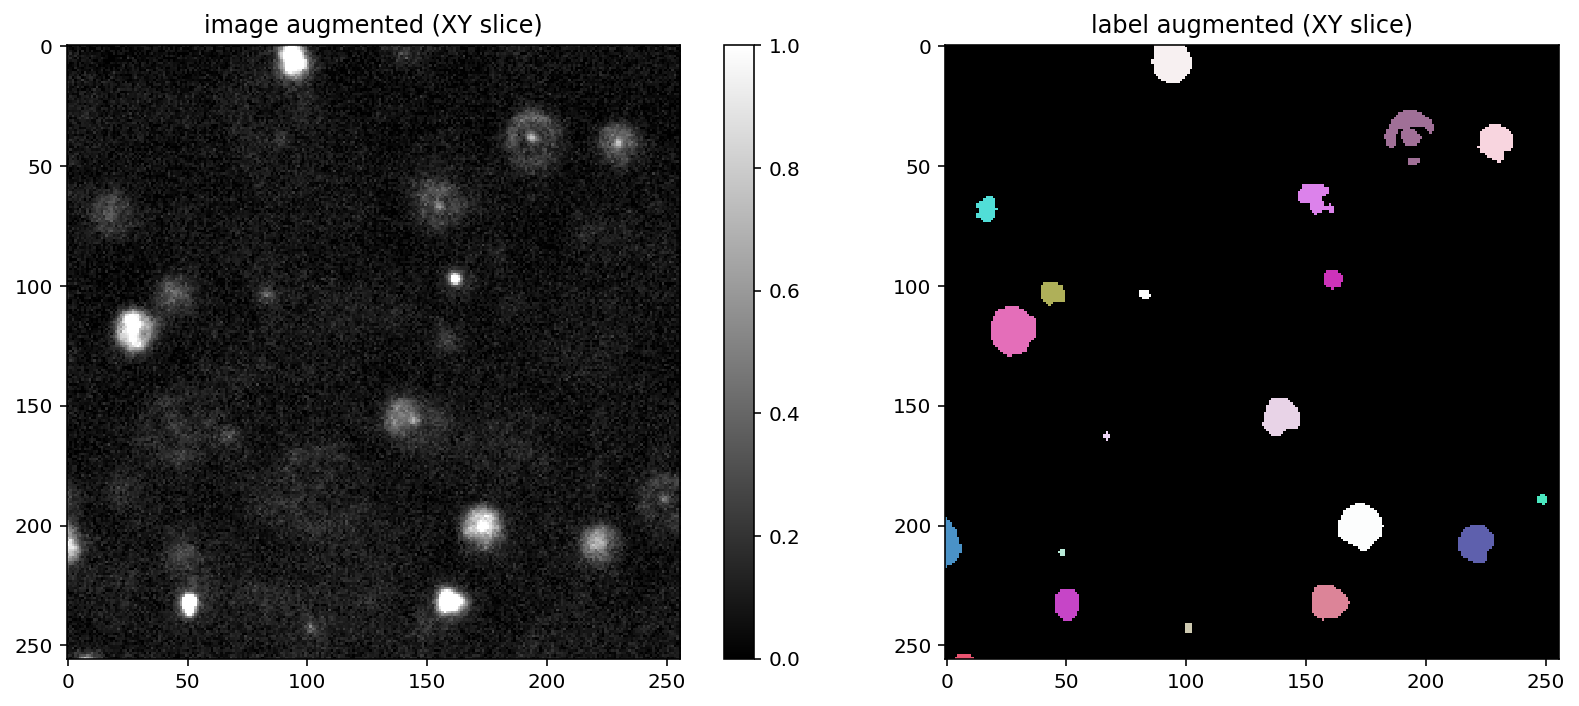

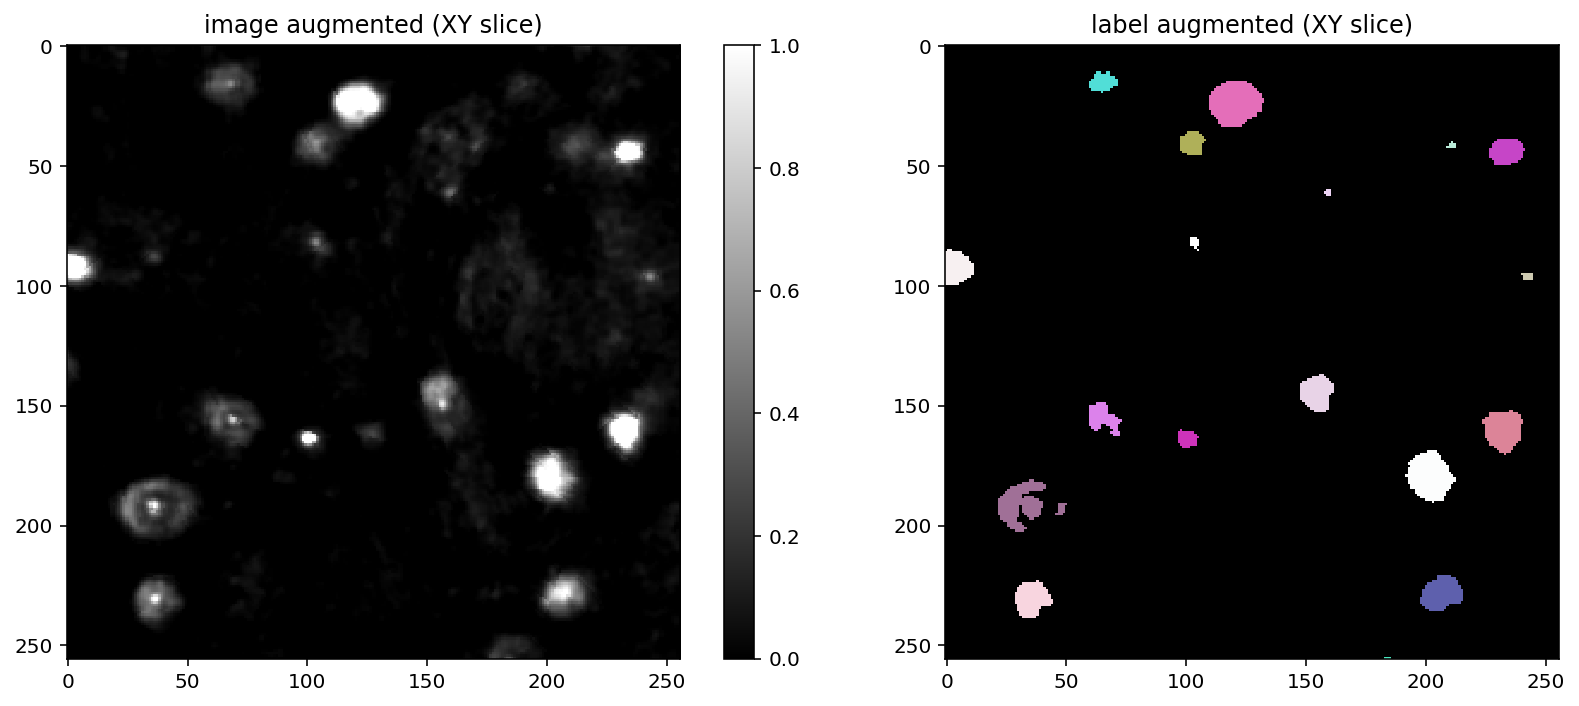

In [14]:
# plot some augmented examples
img, lbl = X_trn[0],Y_trn[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

# Training

We recommend to monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard). You can start it in the shell from the current working directory like this:

    $ tensorboard --logdir=.

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


In [38]:
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
%load_ext tensorboard

tb = TensorBoard('models/stardist_2_no_augmentation', histogram_freq=1)
%tensorboard --logdir models

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 22351), started 0:36:42 ago. (Use '!kill 22351' to kill it.)

In [15]:
quick_demo = False

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5, callbacks=[tb])

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val))#, augmenter=augmenter)
None;

Epoch 1/400
  2/100 [..............................] - ETA: 50:54 - loss: 2.0609 - prob_loss: 0.6266 - dist_loss: 7.1712 - prob_kld: 0.6240 - dist_relevant_mae: 7.1712 - dist_relevant_mse: 100.1857

KeyboardInterrupt: 

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [53]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:04<00:01,  3.41it/s, 0.173 -> 0.000]


Using optimized values: prob_thresh=0.173421, nms_thresh=0.3.
Saving to 'thresholds.json'.


In [10]:
data_dir = '/home/fiche/Data_single_loci/Annotated_data/data_loci'
os.chdir(data_dir)

model = StarDist3D(None, name='stardist_15032021_single_loci', basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.476902, nms_thresh=0.3.


# Evaluation and Detection Performance

Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.

The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.

Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.

In [55]:
# help(matching)

First predict the labels for all validation images:

In [11]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 18/18 [06:43<00:00, 22.40s/it]


Plot a GT/prediction example  

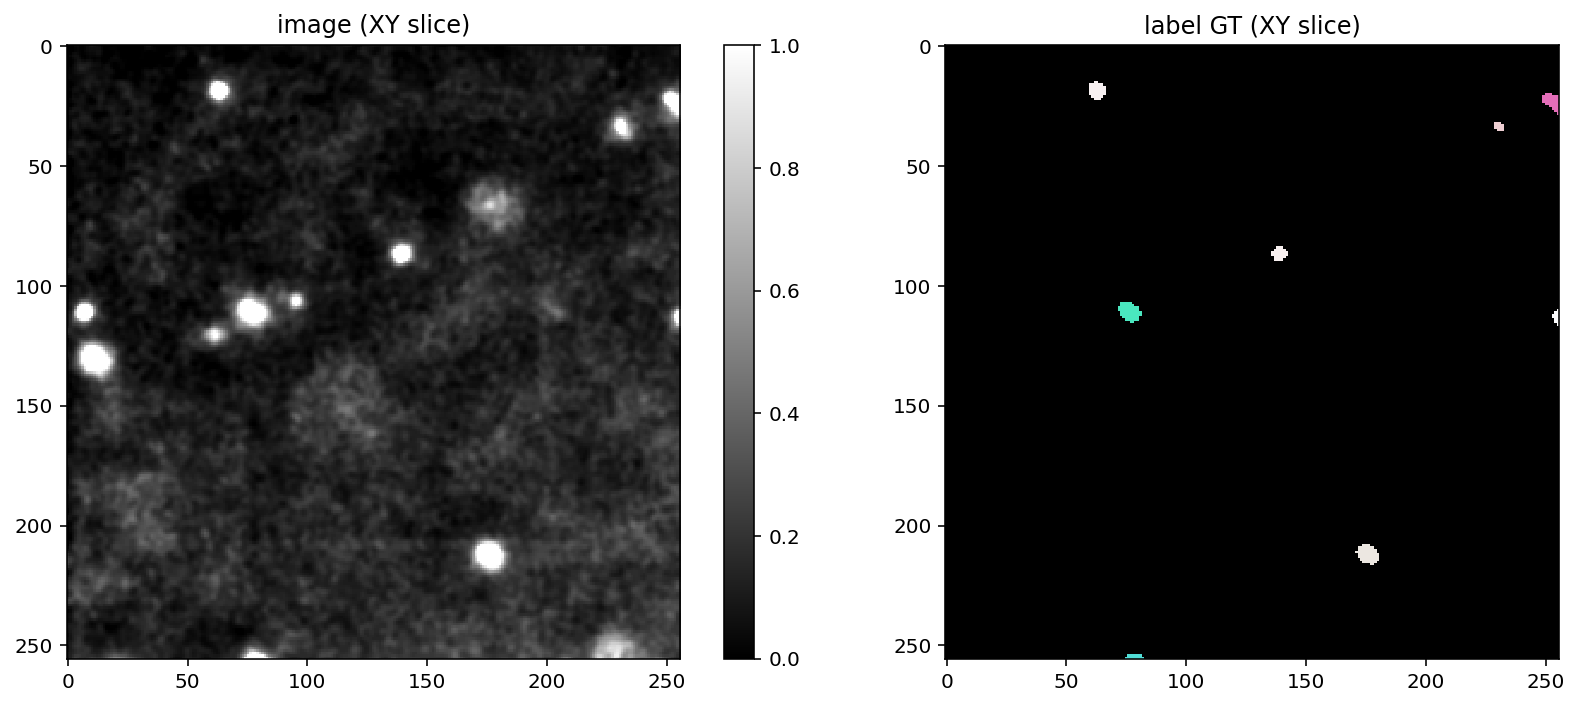

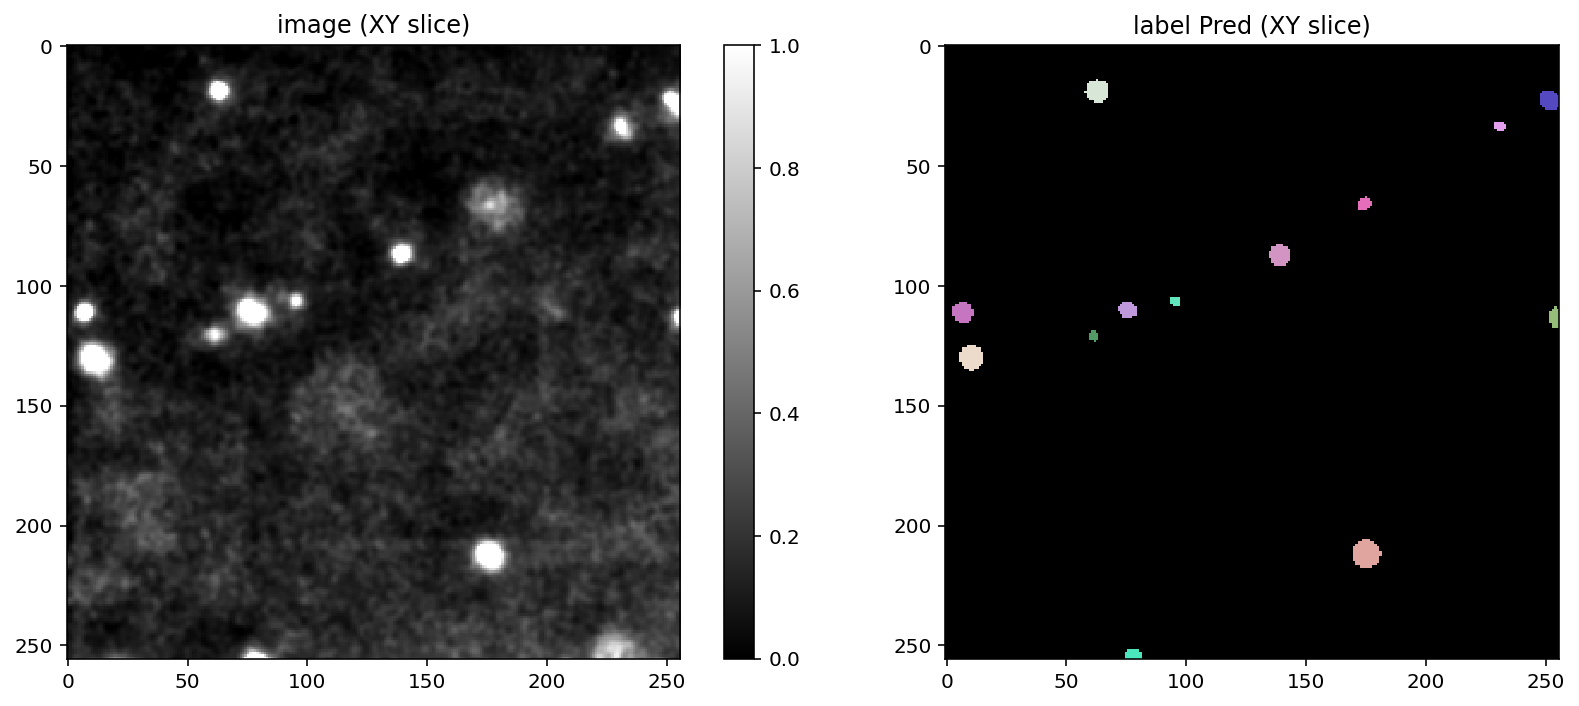

In [12]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.

In [13]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:26<00:00,  2.97s/it]


Example: Print all available matching statistics for $\tau=0.7$

In [14]:
stats[taus.index(0.7)]

DatasetMatching(criterion='iou', thresh=0.7, fp=288, tp=104, fn=611, precision=0.2653061224489796, recall=0.14545454545454545, accuracy=0.1036889332003988, f1=0.1878952122854562, n_true=715, n_pred=392, mean_true_score=0.1112605153973609, mean_matched_score=0.7649160433568561, panoptic_quality=0.1437240623470877, by_image=False)

Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

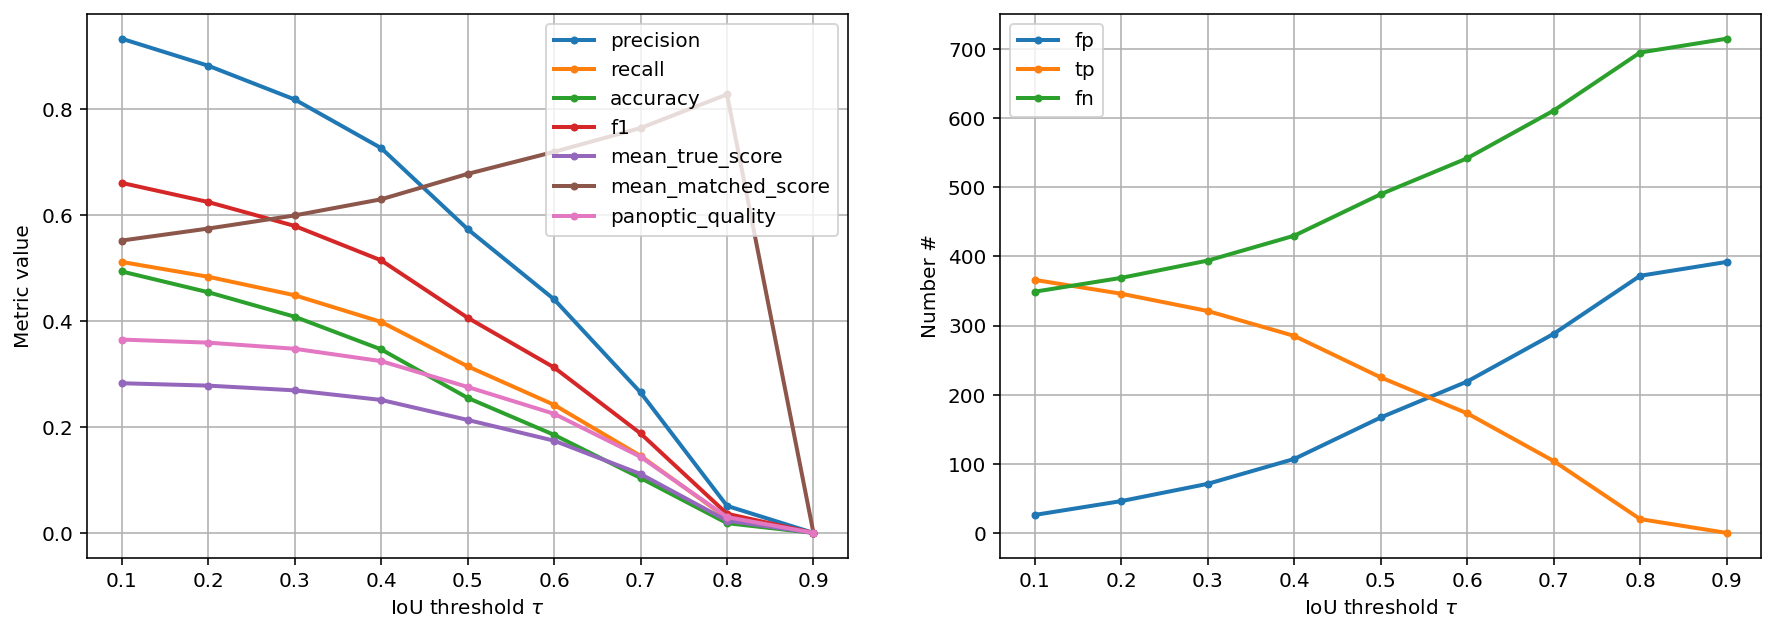

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();